In [1]:
import sys
sys.path.append('../')

In [2]:
from benji_girgs import generation, plotting, utils
import networkit as nk
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [22]:
n=3000
d=2
tau=2.5
alpha = 1.2

g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)

/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:114: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '3000 nodes, tau 2.5, alpha 1.2, d 2')

Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '3000 nodes, tau 2.5, alpha 1.2, d 2')

w_alpha_mean_empirical: 4.332, w_alpha_mean: 5.000


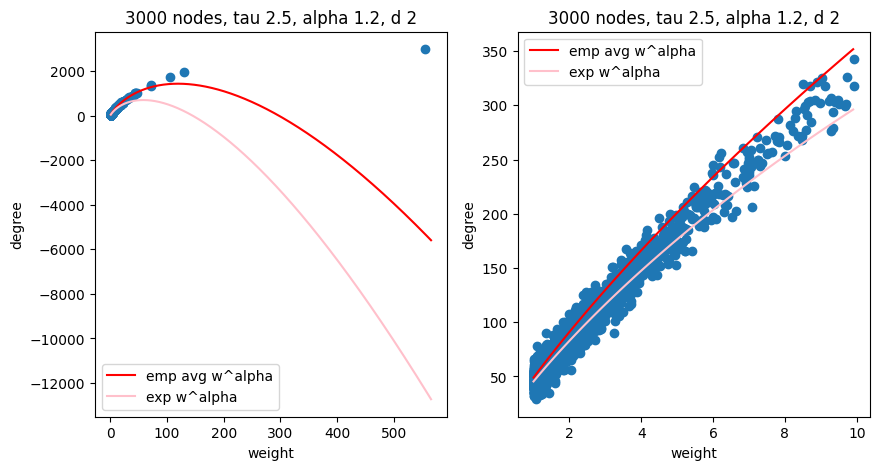

In [23]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
plt.sca(axes[0])

k=max(weights)+10
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

w_mean = (tau-1)/(tau-2)
w_alpha_mean_empirical = np.mean(weights**alpha)
w_alpha_mean = (tau-1)/(tau-1-alpha)

a = w_mean
b = w_mean / (alpha - 1)
c_emp = w_alpha_mean_empirical  * 2**(d*(alpha-1)) * n**(1-alpha) / (1 - alpha)
c = c_emp * w_alpha_mean / w_alpha_mean_empirical

ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.legend()

k=10
plt.sca(axes[1])
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.legend()

print(f'w_alpha_mean_empirical: {w_alpha_mean_empirical:.3f}, w_alpha_mean: {w_alpha_mean:.3f}')

In [123]:
np.linspace(1, 10, 12)

array([ 1.        ,  1.81818182,  2.63636364,  3.45454545,  4.27272727,
        5.09090909,  5.90909091,  6.72727273,  7.54545455,  8.36363636,
        9.18181818, 10.        ])

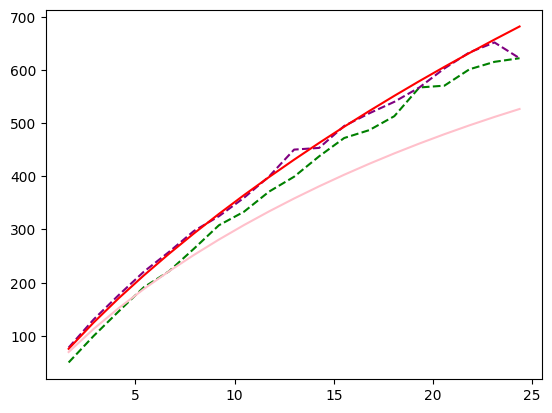

In [151]:
k = 25
npoints = 20
points = np.linspace(1, k, npoints)
midpoints = np.linspace(1, k, 2*(npoints-2) + 3)
midpoints = np.array([midpoints[i] for i in range(len(midpoints)) if i % 2 == 1])
quantiles = []
for i in range(len(points)-1):
    lo, hi = points[i], points[i+1]
    midpoint = midpoints[i]
    quantiles.append(np.quantile(degrees[(lo < weights) & (weights < hi)], [0.2, 0.8]))
quantiles = np.array(quantiles)

plt.plot(midpoints, quantiles[:, 0], color='green', label='0.2 quantile', linestyle='--')
plt.plot(midpoints, quantiles[:, 1], color='purple', label='0.8 quantile', linestyle='--')

ys_emp = (2**d) * ((a + b) * midpoints + c_emp * midpoints**alpha)
ys = (2**d) * ((a + b) * midpoints + c * midpoints**alpha)

plt.plot(midpoints, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(midpoints, ys, color='pink', label='exp w^alpha')

In [18]:
from girg_sampling import girgs

In [28]:
def cgirg_gen(n, d, tau, alpha, desiredAvgDegree=None):
    """Generate a GIRG with C-library"""
    weights = girgs.generateWeights(n, tau)
    scaled_weights = weights
    const = 1
    if desiredAvgDegree is not None:
        const = girgs.scaleWeights(weights, desiredAvgDegree, d, alpha)
        scaled_weights = list(np.array(weights) * const)
    pts = girgs.generatePositions(n, d)
    edges = girgs.generateEdges(scaled_weights, pts, alpha)
    # Make graph from edge list (not adjacency matrix)
    gnx = nx.from_edgelist(edges)
    missing_nodes = set(list(range(n)))
    for node in gnx.nodes:
        missing_nodes.remove(node)
    
    for missing_node in missing_nodes:
        gnx.add_node(missing_node)

    gnk = nk.nxadapter.nx2nk(gnx)
    id2gnk = dict((gnx_id, gnk_id) for (gnx_id, gnk_id) in zip(gnx.nodes(), range(gnx.number_of_nodes())))

    return gnk, edges, weights, pts, const, id2gnk

In [26]:
g, edges, weights, pts, const, id2gnk = cgirg_gen(n, d, tau, alpha, 100.0)
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
degrees2 = [g.degree(v) for v in range(g.numberOfNodes())]
gnk2id = {v: k for k, v in id2gnk.items()}
weights = np.array([weights[gnk2id[i]] for i in range(len(weights))])

NameError: name 'cgirg_gen' is not defined

In [43]:
const

2.8549914027377437

Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '3000 nodes, tau 2.5, alpha 1.2, d 2')

NameError: name 'const' is not defined

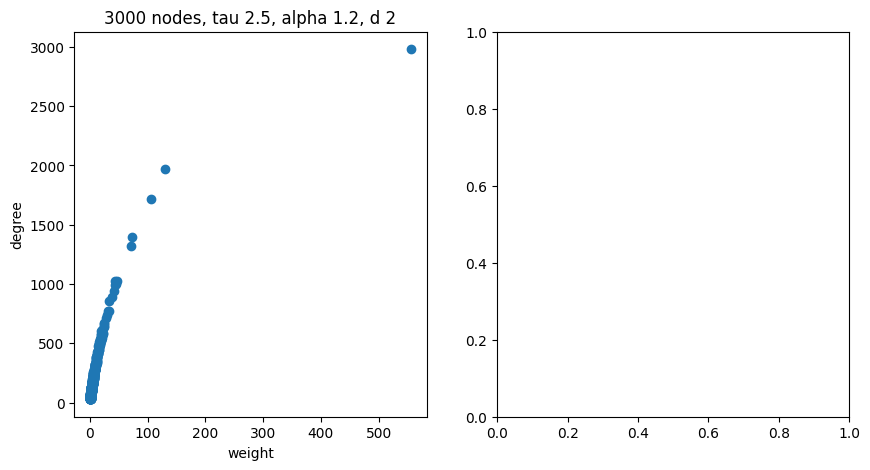

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
plt.sca(axes[0])

k=max(weights)+10
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

w_mean = (tau-1)/(tau-2)
# w_mean = np.mean(weights)
w_alpha_mean_empirical = np.mean(weights**alpha)
w_alpha_mean = (tau-1)/(tau-1-alpha)

# const = 1


a = (n/np.sum(weights)) * w_mean * const**(1/alpha)
b = (n/np.sum(weights)) * w_mean * const**(1/alpha) / (alpha - 1)
c_emp = (n/(np.sum(weights)**(alpha))) *  w_alpha_mean_empirical  * const / (1 - alpha)
c = c_emp * w_alpha_mean / w_alpha_mean_empirical


ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.legend()

k=10
plt.sca(axes[1])
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.legend()

print(a, b, c)
print(f'w_alpha_mean_empirical: {w_alpha_mean_empirical:.3f}, w_alpha_mean: {w_alpha_mean:.3f}')

In [2]:
n=3000
d=2
tau=2.5
alpha = 1.2

g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)

/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:114: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


In [48]:
def simple_bfs_search(g, weights, weight_thresh, num=10, starting=1.3, starting_eps=0.05):
    suitable_starting = np.argwhere(np.abs(weights - starting) < starting_eps).reshape(-1)
    dist_2s = []
    for starting_node in suitable_starting[:num]:
        dists = simple_bfs(g, weights, weight_thresh, starting_node)
        dists2 = {k: len(v) for k, v in dists.items()}
        dist_2s.append(dists2[2])
    return np.median(dist_2s)

def simple_bfs(g, weights, weight_thresh, starting_node):
    dists = {0: [starting_node]}
    visited = set([starting_node])
    dist = 0
    while True:
#         print(dist)
        trigger = False
        new_dist = []
        for node in dists[dist]:
            for nhb in g.iterNeighbors(node):
                if not nhb in visited:
                    visited.add(nhb)
                    if weights[nhb] < weight_thresh:
                        new_dist.append(nhb)
                        trigger = True
                        
        dist += 1
        dists[dist] = new_dist
        if not trigger:
            break
            
    return dists

In [68]:
n=3000
d=2
tau=2.5
alpha = 1.01

weight = 1.3

g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
dist_2s = []
scale_factor_arr = []
for starting_node in suitable_starting[:100]:
    dists = simple_bfs(g, weights, 1.1, starting_node)
    dists2 = {k: len(v) for k, v in dists.items()}
    if len(dists2) < 5:
        continue
    dist_2s.append(dists2[2])
#     print(dists2)
    scale_factors = [dists2[i+1]/dists2[i] for i in range(len(dists2)-1)]
    scale_factor_arr.append(scale_factors)
#     print('; '.join([f'{i+1}/{i}: {scale_factors[i]:.2f}' for i in range(len(dists2)-1)]))
#     print('')

temp = np.array(list(zip(*scale_factor_arr)))
np.median(temp, axis=1)

array([5.        , 3.66666667, 3.21059113, 2.19281046, 1.00364964,
       0.24813433, 0.07549858])

In [103]:
n=3000
d=3
tau=2.5
alphas = [1.01, 1.05, 1.1, 1.2, 1.4, 1.8, 2.5]

weight = 1.3
outs3 = []

for alpha in tqdm(alphas):

    g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
    suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
    dist_2s = []
    scale_factor_arr = []
    for starting_node in suitable_starting[:100]:
        dists = simple_bfs(g, weights, 1.1, starting_node)
        dists2 = {k: len(v) for k, v in dists.items()}
        if len(dists2) < 5:
            continue
        dist_2s.append(dists2[2])
    #     print(dists2)
        scale_factors = [dists2[i+1]/dists2[i] for i in range(len(dists2)-1)]
        scale_factor_arr.append(scale_factors)
    #     print('; '.join([f'{i+1}/{i}: {scale_factors[i]:.2f}' for i in range(len(dists2)-1)]))
    #     print('')

    temp = np.array(list(zip(*scale_factor_arr)))
    outs3.append(np.median(temp, axis=1)[1])

100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


In [104]:
n=3000
d=2
tau=2.5
alphas = [1.01, 1.05, 1.1, 1.2, 1.4, 1.8, 2.5]

weight = 1.3
outs2 = []

for alpha in tqdm(alphas):

    g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
    suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
    dist_2s = []
    scale_factor_arr = []
    for starting_node in suitable_starting[:100]:
        dists = simple_bfs(g, weights, 1.1, starting_node)
        dists2 = {k: len(v) for k, v in dists.items()}
        if len(dists2) < 5:
            continue
        dist_2s.append(dists2[2])
    #     print(dists2)
        scale_factors = [dists2[i+1]/dists2[i] for i in range(len(dists2)-1)]
        scale_factor_arr.append(scale_factors)
    #     print('; '.join([f'{i+1}/{i}: {scale_factors[i]:.2f}' for i in range(len(dists2)-1)]))
    #     print('')

    temp = np.array(list(zip(*scale_factor_arr)))
    outs2.append(np.median(temp, axis=1)[1])

100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


In [105]:
n=3000
d=4
tau=2.5
alphas = [1.01, 1.05, 1.1, 1.2, 1.4, 1.8, 2.5]

weight = 1.3
outs4 = []

for alpha in tqdm(alphas):

    g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
    suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
    dist_2s = []
    scale_factor_arr = []
    for starting_node in suitable_starting[:100]:
        dists = simple_bfs(g, weights, 1.1, starting_node)
        dists2 = {k: len(v) for k, v in dists.items()}
        if len(dists2) < 3:
            continue
        dist_2s.append(dists2[2])
    #     print(dists2)
        scale_factors = [dists2[i+1]/dists2[i] for i in range(len(dists2)-1)]
        scale_factor_arr.append(scale_factors)
    #     print('; '.join([f'{i+1}/{i}: {scale_factors[i]:.2f}' for i in range(len(dists2)-1)]))
    #     print('')

    temp = np.array(list(zip(*scale_factor_arr)))
    outs4.append(np.median(temp, axis=1)[1])

100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


In [106]:
n=3000
d=5
tau=2.5
alphas = [1.01, 1.05, 1.1, 1.2, 1.4, 1.8, 2.5]

weight = 1.3
outs5 = []

for alpha in tqdm(alphas):

    g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
    suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
    dist_2s = []
    scale_factor_arr = []
    for starting_node in suitable_starting[:100]:
        dists = simple_bfs(g, weights, 1.1, starting_node)
        dists2 = {k: len(v) for k, v in dists.items()}
        if len(dists2) < 3:
            continue
        dist_2s.append(dists2[2])
        scale_factors = [dists2[i+1]/dists2[i] for i in range(len(dists2)-1)]
        scale_factor_arr.append(scale_factors)

    temp = np.array(list(zip(*scale_factor_arr)))
    outs5.append(np.median(temp, axis=1)[1])

100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


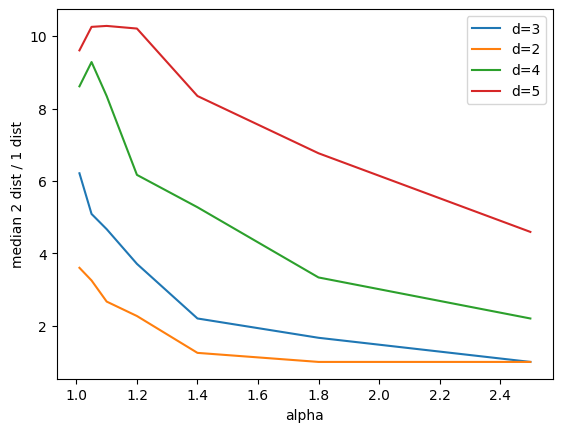

In [107]:
plt.plot(alphas, outs3, label='d=3')
plt.plot(alphas, outs2, label='d=2')
plt.plot(alphas, outs4, label='d=4')
plt.plot(alphas, outs5, label='d=5')
plt.xlabel('alpha')
plt.ylabel('median 2 dist / 1 dist')
plt.legend()

In [4]:
def quick_subgraph(g, indices):
    g2 = nk.graphtools.subgraphFromNodes(g, indices)
    a = list(g2.iterEdges())
    b = list(g2.iterNodes())
    node_map = {}
    i = 0
    for node in b:
        node_map[node] = i
        i += 1
    rev_node_map = {v:k for k, v in node_map.items()}

    g3 = nk.Graph()
    for node in rev_node_map:
        _ = g3.addNode()

    for u, v in tqdm(a):
        _ = g3.addEdge(node_map[u], node_map[v])
        
    return g3

In [5]:
n=3000
d=2
tau=2.5
alphas = alpha=1.2
g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)

/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:114: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


In [10]:
dists = utils.weight_thresh_all_pairs_distances(g, weights, 1.3)
cn_r = utils.fractal_dimensions(dists)
dists2 = utils.sort_out_dist_matrix(dists)

In [13]:
np.median(dists2[:, 2] / dists2[:, 1])

5.714285714285714

In [14]:
cn_r

[0.001001001001001001,
 0.008866866866866868,
 0.053753753753753755,
 0.24848848848848848,
 0.7102002002002002,
 0.9819239239239239,
 1.0007967967967968]

In [15]:
cn_r[2] / cn_r[1]

6.062316550011289

In [18]:
diffs = [cn_r[0]]
for i in range(1, len(cn_r)):
    diffs.append(cn_r[i] - cn_r[i-1])
    
diffs[2] / diffs[1]

5.706541104606769

In [19]:
# Yeah this was never gonnna be equal but anyways....
np.mean(dists2[:, 2] / dists2[:, 1])

5.812537442296266

In [9]:
indices = np.argwhere(weights < 1.3).reshape(-1)

g2 = quick_subgraph(g, indices)
apsp = nk.distance.APSP(g2)
_ = apsp.run()

dists = np.array(apsp.getDistances()).astype(np.int64)
cn_r = []
nchoose2 = g2.numberOfNodes() * (g2.numberOfNodes() - 1)/2
for r in range(1, 10):
    cn_r.append(np.sum(dists < r)/ (2 * nchoose2))

100%|██████████| 3742/3742 [00:00<00:00, 1262373.17it/s]
/scratch/tmp.13281964.bdayan/ipykernel_51187/4181749659.py:7: RuntimeWarning: invalid value encountered in cast
  dists = np.array(apsp.getDistances()).astype(np.int64)


In [45]:
dists.min()

-9223372036854775808

In [44]:
np.sum(dists < 6)
np.sum(dists < 7)


943862

In [38]:
def sort_out_dist_matrix(dists):
    """dists: a square n x n integer matrix of distances.
    
    return: something like
    array([[  1,   5,  30, 131, 431, 354,  28,   0],
           [  1,   9,  47, 202, 479, 231,  11,   0],
           [  1,   4,  19,  86, 317, 486,  67,   0],
           [  1,   0,   0,   0,   0,   0,   0,   0],
           ...
        ])
    I.e. the longest distance was 7 here.
    """
    # Remove - infinities
    new_dists = []
    for vec in dists:
        # distances will look like -9223372036854775808, 0, 1, 2, ...
        distances, counts = np.unique(vec, return_counts=True)
        new_dists.append(counts[distances >= 0])
        
    return np.array(list(zip_longest(*new_dists, fillvalue=0))).T

new_dists = sort_out_dist_matrix(dists)
new_dists2 = np.array(list(zip_longest(*new_dists, fillvalue=0))).T

In [28]:
np.unique(dists[0, :], return_counts=True)

(array([-9223372036854775808,                    0,                    1,
                           2,                    3,                    4,
                           5,                    6]),
 array([  2,   1,   5,  30, 131, 431, 354,  28]))

In [34]:
new_dists[:5]

[array([  1,   5,  30, 131, 431, 354,  28]),
 array([  1,   9,  47, 202, 479, 231,  11]),
 array([  1,   4,  19,  86, 317, 486,  67]),
 array([1]),
 array([  1,   8,  43, 184, 502, 237,   5])]

In [39]:
new_dists2[:5]

array([[  1,   5,  30, 131, 431, 354,  28,   0],
       [  1,   9,  47, 202, 479, 231,  11,   0],
       [  1,   4,  19,  86, 317, 486,  67,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0],
       [  1,   8,  43, 184, 502, 237,   5,   0]])

Text(0.5, 0, 'r')

Text(0, 0.5, 'dist??')

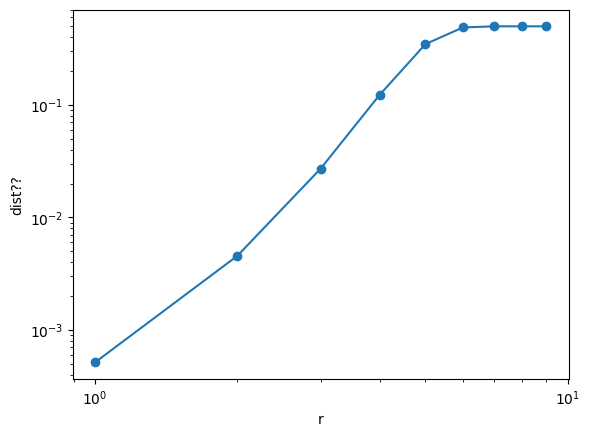

In [174]:
plt.xscale('log')
plt.yscale('log')
plt.plot(list(range(1, 10)), cn_r, marker='o')
plt.xlabel('r')
plt.ylabel('dist??')

In [187]:
len(weights[weights < 1.1])

419

In [ ]:
n=15000
d=2
tau=2.5
alpha=1.3
threshs = [1.3, 2.0, 3.0]
g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
cn_rs = []
rs = np.array(list(range(1, 10)))
for thresh in threshs:
    indices = np.argwhere(weights < thresh).reshape(-1)

    g2 = utils.quick_subgraph(g, indices)
    apsp = nk.distance.APSP(g2)
    _ = apsp.run()

    dists = np.array(apsp.getDistances())
    cn_r = []
    nchoose2 = g2.numberOfNodes() * (g2.numberOfNodes() - 1)/2
    for r in rs:
        cn_r.append(np.sum(dists < r)/ (2 * nchoose2))
        
    cn_rs.append(cn_r)
    
    
plt.xscale('log')
plt.yscale('log')
for cn_r, thresh in zip(cn_rs, threshs):
    plt.plot(rs, cn_r, marker='o', label=f'{thresh}; d=2')
plt.xlabel('r')
plt.ylabel('dist??')


d=3

g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
cn_rs = []
for thresh in threshs:
    indices = np.argwhere(weights < thresh).reshape(-1)

    g2 = utils.quick_subgraph(g, indices)
    apsp = nk.distance.APSP(g2)
    _ = apsp.run()

    dists = np.array(apsp.getDistances())
    cn_r = []
    nchoose2 = g2.numberOfNodes() * (g2.numberOfNodes() - 1)/2
    for r in range(1, 10):
        cn_r.append(np.sum(dists < r)/ (2 * nchoose2))
        
    cn_rs.append(cn_r)
    
for cn_r, thresh in zip(cn_rs, threshs):
    plt.plot(rs, cn_r, marker='o', label=f'{thresh}; d=3')
    
plt.plot(rs, cn_r[0] * rs**3, color='grey', linestyle='--', label='r^3')
plt.plot(rs, cn_r[0] * rs**2, color='pink', linestyle='--', label='r^2')
plt.plot(rs, cn_r[0] * rs, color='purple', linestyle='--', label='r^1')

plt.legend()

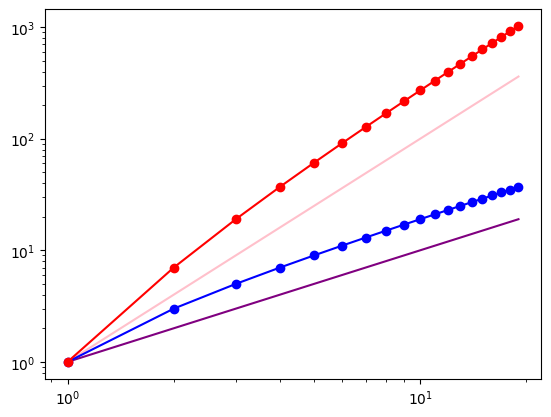

In [201]:
i_s = np.array([i for i in range(1, 20)])
ys = [i**2 - (i-1)**2 for i in range(1, 20)]
ys2 = [i**3 - (i-1)**3 for i in range(1, 20)]
plt.plot(i_s, i_s**2, color='pink')
plt.plot(i_s, i_s, color='purple')
plt.xscale('log')
plt.yscale('log')
plt.plot(i_s, ys, marker='o', color='b')
plt.plot(i_s, ys2, marker='o', color='r')

In [163]:
apsp = nk.distance.APSP(g2)
apsp.run()

In [151]:
dists = np.array(apsp.getDistances())
cn_r = []
nchoose2 = g3.numberOfNodes() * (g3.numberOfNodes() - 1)/2
for r in range(1, 10):
    cn_r.append(np.sum(dists < r)/ (2 * nchoose2))

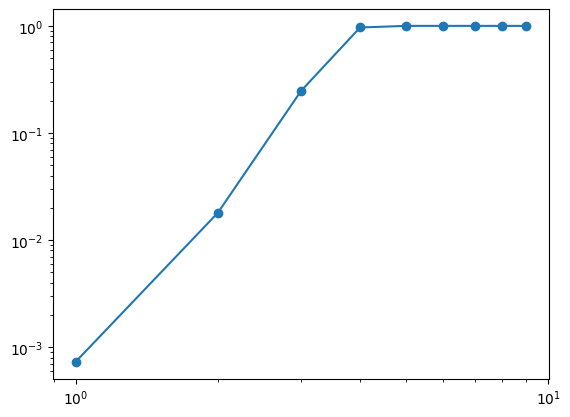

In [158]:
plt.xscale('log')
plt.yscale('log')
plt.plot(list(range(1, 10)), cn_r, marker='o')
plt.xlabel('r')
plt.ylabel('dist??')

In [98]:
g, edges, weights, pts = generation.generate_GIRG_nk(n, 5, tau, 1.2)
suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
dist_2s = []
scale_factor_arr = []
for starting_node in suitable_starting[:100]:
    dists = simple_bfs(g, weights, 1.1, starting_node)
    dists2 = {k: len(v) for k, v in dists.items()}
    scale_factors = [dists2[i+1]/dists2[i] for i in range(len(dists2)-1)]
    scale_factor_arr.append(scale_factors)

In [99]:
temp = np.array(list(zip(*scale_factor_arr)))

In [101]:
np.median(temp, axis=1)

array([23.        , 10.61204013,  0.66128482,  0.        ])

In [102]:
dists2

{0: 1, 1: 25, 2: 252, 3: 158, 4: 0}

In [22]:
n=3000
d=3
tau=2.5
alpha = 1.2

weight = 1.3

for _ in range(4):
    g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
    suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
    dists = simple_bfs(g, 1.5, suitable_starting[0])
    dists2 = {k: len(v) for k, v in dists.items()}
    print(dists2)

{1: 1, 2: 22, 3: 280, 4: 1021, 5: 72, 6: 0}
{1: 1, 2: 26, 3: 293, 4: 969, 5: 45, 6: 0}
{1: 1, 2: 33, 3: 385, 4: 957, 5: 13, 6: 0}
{1: 1, 2: 30, 3: 366, 4: 991, 5: 21, 6: 0}


In [24]:
n=3000
d=2
tau=2.5
alpha = 2.0

weight = 1.3

for _ in range(4):
    g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
    suitable_starting = np.argwhere(np.abs(weights - 1.3) < 0.05).reshape(-1)
    dists = simple_bfs(g, 1.5, suitable_starting[0])
    dists2 = {k: len(v) for k, v in dists.items()}
    print(dists2)

{1: 1, 2: 2, 3: 5, 4: 12, 5: 29, 6: 56, 7: 71, 8: 90, 9: 119, 10: 141, 11: 152, 12: 158, 13: 181, 14: 167, 15: 92, 16: 17, 17: 4, 18: 0}
{1: 1, 2: 5, 3: 12, 4: 27, 5: 40, 6: 55, 7: 74, 8: 86, 9: 137, 10: 183, 11: 243, 12: 240, 13: 168, 14: 68, 15: 12, 16: 3, 17: 0}
{1: 1, 2: 3, 3: 9, 4: 28, 5: 43, 6: 62, 7: 94, 8: 124, 9: 151, 10: 213, 11: 227, 12: 187, 13: 123, 14: 63, 15: 29, 16: 5, 17: 0}
{1: 1, 2: 8, 3: 20, 4: 41, 5: 65, 6: 85, 7: 141, 8: 197, 9: 211, 10: 179, 11: 144, 12: 117, 13: 83, 14: 46, 15: 12, 16: 3, 17: 0}


In [20]:
np.argwhere(np.abs(weights - 1.5) < 0.05).reshape(-1)

array([   1,    3,    7,   31,   33,   36,   56,   99,  116,  141,  155,
        172,  184,  210,  260,  262,  271,  300,  331,  347,  356,  358,
        378,  381,  407,  433,  436,  461,  498,  502,  509,  517,  542,
        565,  599,  617,  648,  651,  657,  667,  668,  689,  711,  724,
        747,  767,  776,  778,  780,  845,  855,  862,  882,  927,  936,
        956,  976, 1011, 1021, 1050, 1061, 1068, 1070, 1071, 1119, 1120,
       1122, 1136, 1166, 1182, 1193, 1202, 1204, 1208, 1218, 1239, 1252,
       1263, 1270, 1276, 1326, 1343, 1355, 1367, 1392, 1487, 1494, 1540,
       1553, 1554, 1562, 1579, 1640, 1647, 1656, 1657, 1665, 1673, 1694,
       1703, 1779, 1819, 1840, 1896, 1906, 1922, 1970, 1971, 1980, 2007,
       2009, 2057, 2058, 2072, 2088, 2118, 2128, 2138, 2141, 2156, 2165,
       2178, 2217, 2227, 2233, 2287, 2293, 2301, 2304, 2321, 2343, 2371,
       2384, 2398, 2423, 2458, 2466, 2470, 2473, 2485, 2493, 2495, 2500,
       2569, 2581, 2585, 2619, 2627, 2633, 2641, 26

In [14]:
dists2 = {k: len(v) for k, v in dists.items()}
dists2

{1: 1, 2: 19, 3: 149, 4: 623, 5: 582, 6: 12, 7: 0}

In [27]:
a, b, c_emp

(1.0042439025062944, 5.021219512531473, -1.2367300747224501)

In [62]:
n = 10000000

w_mean = (tau-1)/(tau-2)
w_alpha_mean = np.mean(weights**alpha)
w_alpha_mean2 = (tau-1)/(tau-1-alpha)
a = w_mean
b = w_mean / (alpha - 1)
c = w_alpha_mean  * 2**(d*(alpha-1)) * n**(1-alpha) / (1 - alpha)
c2 = c * w_alpha_mean2 / w_alpha_mean
print(f'{a:.3f} {b:.3f} {c:.3f} {c2:.3f}')

3.000 15.000 -0.265 -0.330


In [63]:
1-alpha

-0.19999999999999996

In [64]:
10000000000 **(-0.2)

0.009999999999999997

In [65]:
w_mean
w_alpha_mean

3.0

4.023787663617149

In [14]:
n=1000
d=2
tau=2.5
alphas = np.arange(1.1, 10.0, 0.4)
outs = []

for alpha in tqdm(alphas):
    for _ in range(3):
        g, edges, weights, pts = generation.cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
        percs = utils.get_perc_lower_common_nhbs(g, 2000)
        outs.append((alpha, np.median(percs)))


# plt.scatter([out[0] for out in outs], [out[1] for out in outs])

100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Text(0.5, 0, 'alpha')

Text(0, 0.5, 'median % common neighbours')

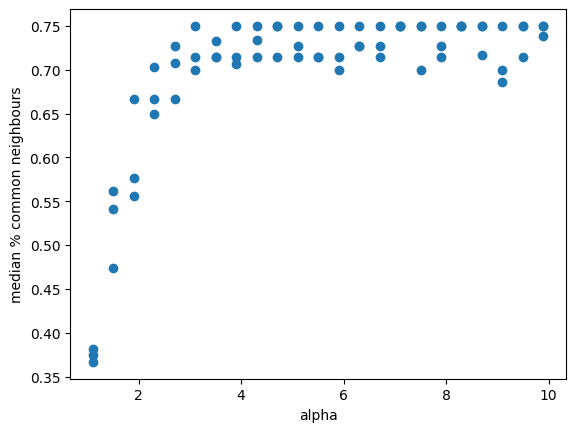

In [15]:
plt.scatter([out[0] for out in outs], [out[1] for out in outs])
plt.xlabel('alpha')
plt.ylabel('median % common neighbours')

In [20]:
percs

[0.6363636363636364,
 0.6,
 0.6666666666666666,
 0.8888888888888888,
 0.6666666666666666,
 0.75,
 0.8333333333333334,
 0.8,
 0.5384615384615384,
 0.8461538461538461,
 0.7142857142857143,
 0.75,
 0.6666666666666666,
 0.8888888888888888,
 0.6,
 0.8571428571428571,
 0.7692307692307693,
 0.75,
 0.18181818181818182,
 0.4642857142857143,
 0.8333333333333334,
 0.7692307692307693,
 0.6875,
 0.8571428571428571,
 0.6666666666666666,
 0.9655172413793104,
 0.5714285714285714,
 0.5555555555555556,
 0.8888888888888888,
 0.75,
 0.5,
 0.8,
 0.75,
 0.5,
 0.75,
 0.3584905660377358,
 0.8,
 0.8888888888888888,
 0.9166666666666666,
 0.7142857142857143,
 0.631578947368421,
 0.5454545454545454,
 0.75,
 0.75,
 0.8,
 0.45454545454545453,
 0.75,
 0.9523809523809523,
 0.5,
 0.42105263157894735,
 0.46153846153846156,
 0.34375,
 0.5555555555555556,
 0.6666666666666666,
 0.6,
 0.8,
 0.2682926829268293,
 0.75,
 0.8648648648648649,
 0.8,
 0.5,
 0.875,
 0.6,
 0.7142857142857143,
 0.9523809523809523,
 0.322580645161290

In [13]:
g, edges, weights, pts = generation.cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
nk.overview(g)

Network Properties:
nodes, edges			1000, 5526
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.011063
clustering coefficient		0.692514
min/max/avg degree		1, 210, 11.052000
degree assortativity		0.219826
number of connected components	1
size of largest component	1000 (100.00 %)


In [21]:
edges = list(g.iterEdges())

In [23]:
edges[0:10]

[(0, 1),
 (0, 270),
 (0, 133),
 (0, 388),
 (0, 135),
 (0, 132),
 (0, 251),
 (0, 65),
 (0, 129),
 (0, 235)]

In [24]:
dijkstra = nk.distance.Dijkstra(g, 0, True, True, 1)
dijkstra.run()

In [27]:
dijkstra.distance(1)
dijkstra.distance(2)

1.0

2.0

In [34]:
dijkstra.getPath(2)

[0, 133, 2]

In [35]:
g.removeEdge(0, 1)

In [44]:
biBFS = nk.distance.BidirectionalBFS(g, 0, 1, True)

In [46]:
biBFS.run()

In [38]:
biBFS.getPath()

[65]

In [40]:
biBFS.getDistance()

2.0

In [50]:
source, target = edges[1000]
source, target

(56, 456)

In [51]:
g.removeEdge(source, target)
biBFS = nk.distance.BidirectionalBFS(g, source, target, True)
biBFS.run()

In [52]:
biBFS.getPath()

[659]

In [55]:
preds = biBFS.getPredecessors()

In [64]:
preds = np.array(preds)


In [65]:
np.sum(preds==0)

979

In [68]:
np.unique(preds)

array([  0,  56, 659])

In [70]:
np.argwhere(preds==56).reshape(-1)

array([  1,  55,  56, 132, 134, 135, 161, 163, 165, 250, 277, 455, 653,
       659, 660, 661, 662, 718])

In [6]:
n=1000
d=2
tau=2.5
alpha=2.0
from girg_sampling import girgs

def cgirg_gen(n, d, tau, alpha, desireAvgDegree=None):
    """Generate a GIRG with C-library"""
    weights = girgs.generateWeights(n, tau)
    if desireAvgDegree is not None:
        weights = list(np.array(weights) * girgs.scaleWeights(weights, desireAvgDegree, d, alpha))
    pts = girgs.generatePositions(n, d)
    edges = girgs.generateEdges(weights, pts, alpha)
    # Make graph from edge list (not adjacency matrix)
    gnx = nx.from_edgelist(edges)
    gnk = nk.nxadapter.nx2nk(gnx)
    id2gnk = dict((gnx_id, gnk_id) for (gnx_id, gnk_id) in zip(gnx.nodes(), range(gnx.number_of_nodes())))

    return gnk, edges, weights, pts, id2gnk


In [34]:
n=5000
d=2
tau=2.5
alpha=1.01


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
    #     print(int(biBFS.getDistance())
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([38801,  1199]))

(array([1, 2]), array([39561,   439]))

(array([1, 2]), array([38212,  1788]))

In [33]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
    #     print(int(biBFS.getDistance())
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2, 3]), array([39212,   787,     1]))

(array([0, 1, 2]), array([    2, 39001,   997]))

(array([1, 2]), array([39356,   644]))

In [35]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([39593,   407]))

(array([1, 2, 3]), array([39272,   727,     1]))

(array([1, 2, 3]), array([38939,  1058,     3]))

In [52]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
    edges = list(g.iterEdges())
    outs = []
    low, up = np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)
    for _ in range(40000 * 12):
        s, t = edges[np.random.choice(len(edges))]
        degs = [degrees[s], degrees[t]]
        degs.sort()
        if degs[0] > low or degs[1] < up:
            continue
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([39972,   974]))

(array([1, 2]), array([41594,  1349]))

(array([1, 2]), array([41166,  1803]))

In [78]:
n=40000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
    edges = list(g.iterEdges())
    outs = []
    low, up = np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)
    for _ in range(40000 * 12):
        s, t = edges[np.random.choice(len(edges))]
        degs = [degrees[s], degrees[t]]
        degs.sort()
        if degs[0] > low or degs[1] < up:
            continue
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2, 3]), array([40016,  1205,     2]))

(array([1, 2]), array([39622,  1085]))

(array([1, 2, 3]), array([36288,  1776,    11]))

In [90]:
n=10000
d=3
tau=2.4
alpha=1.5

g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)

outs = []
for _ in range(10):
    v = np.random.choice(g.numberOfNodes())
    bfs = nk.distance.BFS(g, source=v, storePaths=True, storeNodesSortedByDistance=True)
    bfs.run()
    dists = bfs.getDistances()
    outs.append(np.unique(dists, return_counts=True)[1])

In [91]:
outs

[array([   1,   21, 7658, 2320]),
 array([   1,  126, 9228,  645]),
 array([   1,   77, 8575, 1347]),
 array([   1,   24, 4237, 5738]),
 array([   1,   33, 2861, 7105]),
 array([   1,   35, 5402, 4562]),
 array([   1,   72, 8743, 1184]),
 array([   1,   27, 8062, 1910]),
 array([   1,   91, 9087,  821]),
 array([   1,   23, 7761, 2215])]

In [92]:
g.degree(v)

23

In [93]:
gnk2id = {v:k for k, v in id2gnk.items()}

In [97]:
w = weights[gnk2id[v]]
w
r = w**(1/d)
r
r**d

1.2376200838672948

1.0736493103334088

1.2376200838672948

In [98]:
degrees2 = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
degrees = [0]*len(degrees2)
for i, x in enumerate(degrees2):
    degrees[gnk2id[i]] = x


Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '10000 nodes, tau 2.4, alpha 1.5, d 3')

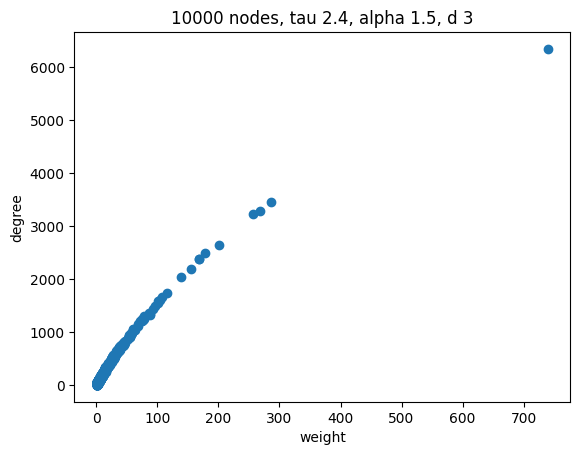

In [100]:
plt.scatter(weights, degrees)
plt.xlabel('weight')
plt.ylabel('degree')
plt.title('10000 nodes, tau 2.4, alpha 1.5, d 3')

Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '10000 nodes, tau 2.4, alpha 1.5, d 3')

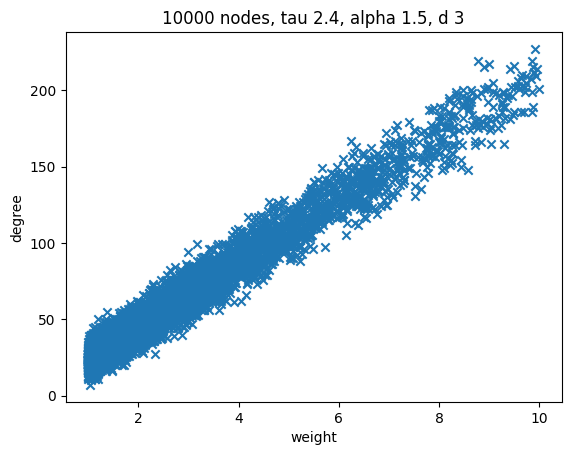

In [103]:
weights, degrees = np.array(weights), np.array(degrees)
plt.scatter(weights[weights < 10], degrees[weights < 10], marker='x')
plt.xlabel('weight')
plt.ylabel('degree')
plt.title('10000 nodes, tau 2.4, alpha 1.5, d 3')

In [41]:
np.quantile(weights, q=[0.25, 0.5, 0.75])

array([1.21491151, 1.59952941, 2.56272572])

In [48]:
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)

array([13, 34])

In [45]:
np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)

array([ 106, 1566, 1247, ...,   10,    8,   12])

In [49]:
a = [1, 2, 3, 5, -1]
a.sort()
a

[-1, 1, 2, 3, 5]

In [93]:
edges[:5]

[(985, 726), (9, 726), (412, 726), (872, 726), (781, 726)]

In [94]:
g.hasEdge(985, 726)

False

In [95]:
edges2 = list(g.iterEdges())

In [96]:
edges2[:5]

[(0, 1), (0, 281), (0, 282), (0, 152), (0, 221)]

In [97]:
(0, 1) in edges

False

In [89]:
stuff = []
for _ in edges:
    stuff = stuff + list(_)

In [91]:
min(stuff)
max(stuff)

0

999